# AI 3601 Homework 2 
## Due: 23:59:59 (GMT +08:00), April 11, 2024 ##

## 1 Environment--Random Walk

State space: Like the picture following (in the picture $n=7$), there are $n$ states {$S_1,S_2,...,S_{n-2},Terminal\_ left,Terminal\_ right$}

![](./random_walk.png)

Action space: In the state of {$S_1,...,S_{n-2}$} , we can choose from {$LEFT$,$RIGHT$} ;  in the state of {$Terminal\_ left,Terminal\_ right$} , we finish the episode.

Reward: When the agent is in state $S_{n-2}$ , it will get a reward of $1$ with the action $RIGHT$ . Agent gets **reward 0 in other condition**.

Policy: uniformly sampling from {$LEFT$,$RIGHT$}.

Before coding, you are required to **compute the true Value function** for arbitrary number of states (you don't have to consider the marginal cases where $n\le 2$).

In [1]:
import numpy as np
import copy
import random
from matplotlib import pyplot as plt
import itertools

In [2]:
class RandomWalk:
    def __init__(self, num_of_states):
        self.num_of_states=num_of_states
        self.state2id={"terminal_0":0,"terminal_1":num_of_states-1}
        for i in range(1, num_of_states-1):
            self.state2id[f"S{i}"] = i
        self.rewards={"terminal_0":0,"terminal_1":1}
        """ Modify here. """
        self.true_value = [
            n / (num_of_states-1) for n in range(1, num_of_states - 1)
        ]  # 需要提前计算好真实的值函数，放在这里，num_of_state的函数       
        """ END. """
        self.start_id=num_of_states//2
        self.step=0

    def reset(self):
        self.step=0
        return self.start_id

    def get_next_state_reward(self,id_):
        self.step+=1
        if(id_==self.state2id['terminal_0']) or (id_==self.state2id["terminal_1"]):
            return (None,None)
        else:
            if(np.random.random())>0.5:
                next_state=id_-1
            else:
                next_state=id_+1

        reward=0
        if(next_state==self.state2id["terminal_1"]):
            reward=self.rewards["terminal_1"]
        elif(next_state==self.state2id["terminal_0"]):
            reward=self.rewards["terminal_0"]
        return (next_state,reward)

# classa = RandomWalk(6)
# print(classa.true_value)


### 1.1 Value Function Approximation


Here, we will implement 2 algorithms: (A)Monte-Carlo methods and (B)Temporal Difference Learning. Then, you are required to answer the following **2** questions.

### (A)Monte-Carlo methods

For n episodes:

&nbsp; &nbsp;    (1)run episode and get $G_{t}$

&nbsp; &nbsp;      (2)update value function and back to (1)

**iteration function**: $$V(S_{t})\leftarrow V(S_{t})+\alpha(G_{t}-V(S_{t})) $$

Here you are required to implement  $run\_ mc\_ algo()$ . It returns a two-layer list $ans$, like [ [0,0,0,0,0] , [0,0,0,0,0] ……] 

The $i_{th}$ element of $ans$ means the value function after $i_{th}$ episodes iteration

In [ ]:
########################

#alpha : parameter of MC algorithm : float
#initial_val : the initial value function , list :[]
#num_of_episodes: the episodes the algo would take , int
#env : an environment ,Class RandomWalk

########################


def run_mc_algo(alpha,initial_val,num_of_episodes,env:RandomWalk):
    """ YOUR CODE HERE """

    return_value_set=[[0.0,]*(env.num_of_states-2)]*num_of_episodes
    # 对于每一轮，使用get_next_state_reward进行探索直到返回(None,None)，得到G，reset重启，第i行存储更新i轮后的值函数
    return_value_set[0]=copy.deepcopy(initial_val) # 复制初始值函数

    for i in range(num_of_episodes):
        cur_state=env.reset()
        gain = 0
        state_list = []  # 只有最后一步可能有为1的reward，否则都为0，但是要记录当前是第几个step，步数-1的gamma(没有gamma)
        while True:
            next_state, reward=env.get_next_state_reward(cur_state)
            if(next_state==None):
                # 终止状态无需记录下来，没有用
                break
            gain = reward  # 这样写是因为只有终点有1的reward，其他都是0
            state_list.append(cur_state)
            cur_state=next_state

        for state in state_list:
            # 重复利用
            return_value_set[i][state - 1] = return_value_set[i][state - 1] + alpha * (gain - return_value_set[i][state - 1])

        if i!=num_of_episodes-1:
            return_value_set[i+1] = copy.deepcopy(return_value_set[i])  # 复制当前值函数到下一轮

    # print("The value function is:", return_value_set[-1])

    """ END CODE HERE """
    return return_value_set

### (B)Temporal Difference Learning

given $n$, $\gamma$

Loop for each episodes:

&nbsp;&nbsp; Initialize Value Function

&nbsp;&nbsp; Loop for step in each episode:

&nbsp; &nbsp;   &nbsp; &nbsp;  (1)Take action and observe next state S' and Reward

&nbsp;  &nbsp; &nbsp; &nbsp;   (2)Update value function and $S\leftarrow S'$


**iteration function**: $$V(S)\leftarrow V(S)+\alpha(R+\gamma V(S')-V(S)) $$

Here you are required to implement  $run\_ td\_ algo()$ . It returns a two-layer list $ans$, like [ [0,0,0,0,0] , [0,0,0,0,0] ……] 

The $i_{th}$ element of $ans$ means the value function after $i_{th}$ episodes iteration

In [4]:
########################
#alpha : parameter of TD algorithm : float
#gamma : parameter of TD algorithm : float
#initial_val : the initial value function , list :[]
#num_of_episodes: the episodes the algo would take , int
#env : an environment ,Class RandomWalk

########################

def run_td_algo(alpha,gamma,initial_val,num_of_episodes,env:RandomWalk):
    """ YOUR CODE HERE """

    return_value_set=[[0,]*(env.num_of_states-2)]*num_of_episodes
    return_value_set[0]=copy.deepcopy(initial_val) # 复制初始值函数

    for i in range(num_of_episodes):
        cur_state=env.reset()
        while True:
            next_state, reward=env.get_next_state_reward(cur_state)
            if(next_state==None):
                # 该状态就是终止状态，则无需记录下来，没有用
                break
            # 可能遇到next_state就是终点的情况，按照0处理
            if next_state == env.state2id["terminal_1"] or next_state == env.state2id["terminal_0"]:
                next_state_value = 0
            else:
                next_state_value = return_value_set[i][next_state-1]
            return_value_set[i][
                cur_state - 1] += alpha * (reward + gamma * next_state_value - return_value_set[i][cur_state - 1])
            cur_state=next_state

        if i != num_of_episodes - 1:
            return_value_set[i + 1] = copy.deepcopy(return_value_set[i])  # 复制当前值函数到下一轮

    # print("return_value_set", return_value_set[-1])

    """ END CODE HERE """
    return return_value_set


In [5]:
def RMS_error(true_value,predict_value):
    t_=np.array(true_value)-np.array(predict_value)
    return np.sqrt(np.sum(np.power(t_,2))/len(true_value))    

### 1.2 Run two algorithms and Visualization

Here, we try to run two algorithms in our environments with 5 states or 11 states. You should run and submit the following code without editing. **Your output will be one of the criteria we use to score**. Since this code block is expected to take a while, it is recommended that you debug your code before fully running the visualization.

In [6]:
def run_mc_and_td(env, alpha_mc, alpha_td, init_value, max_episode):
    initial_value=[init_value,]*(env.num_of_states-2)

    mc_loss, td_loss = [], []

    for j in range(len(alpha_mc)):
        mc_loss_=np.zeros((max_episode,))
        for i in range(max_episode):
            t=run_mc_algo(alpha_mc[j],initial_value,max_episode,env)
            mc_loss_+=np.array([RMS_error(env.true_value,t[z]) for  z in range(max_episode)])/max_episode

        mc_loss.append(list(mc_loss_))

    for j in range(len(alpha_td)):
        td_loss_=np.zeros((max_episode,))
        for i in range(max_episode):
            t=run_td_algo(alpha_td[j],1,initial_value,max_episode,env)
            td_loss_+=np.array([RMS_error(env.true_value,t[z]) for  z in range(max_episode)])/max_episode

        td_loss.append(list(td_loss_))
    
    return mc_loss, td_loss

(0.0, 0.24314279180521178)

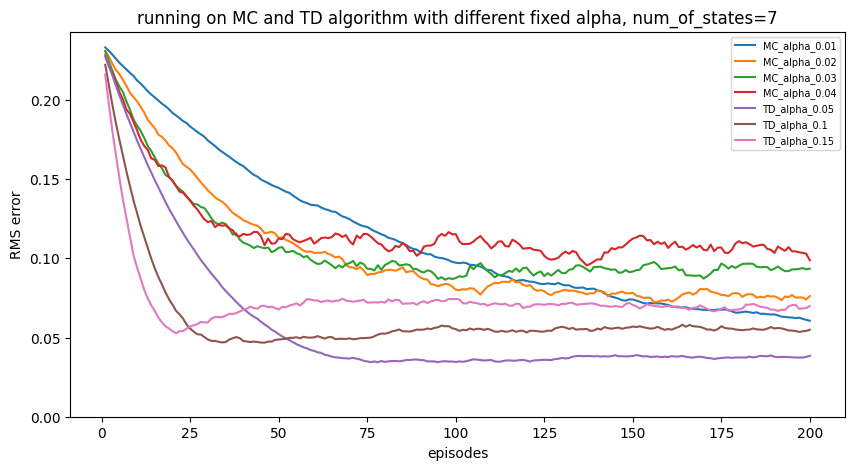

In [7]:
value=0.5
num_of_states=7
env=RandomWalk(num_of_states)
max_episode=200

alpha_mc=[0.01,0.02,0.03,0.04]
alpha_td=[0.05,0.1,0.15]

mc_loss, td_loss = run_mc_and_td(env, alpha_mc, alpha_td, value, max_episode)

x_axis = [i+1 for i in range(max_episode)]
fig=plt.figure(figsize=(10,5))
plt.title(f"running on MC and TD algorithm with different fixed alpha, num_of_states={env.num_of_states}")
plt.xlabel("episodes")
plt.ylabel("RMS error")
for i in range(len(mc_loss)) :
    plt.plot(x_axis, mc_loss[i][:max_episode],label="MC_alpha_"+str(alpha_mc[i]))
for i in range(len(td_loss)) :
    plt.plot(x_axis, td_loss[i][:max_episode],label="TD_alpha_"+str(alpha_td[i]))
plt.legend(prop={"size":7})
plt.ylim(bottom=0)

**Questions**

- Discuss the impact of hyper-parameters like $\alpha$ to $MC$ and $TD$.

**Answer**: 

- Discuss the difference between two algorithms.
- For MC, the RMSE of large alpha decrease faster than small alpha at primary episodes, but converge(not exactly, just jitter with a certain range) earlier and have worse performance. Although small alpha make RMSE decrease slow, it goes down continuously, maybe really converge after many episodes——MC with small alpha converges slowly.
- For TD, it has similar regularity to MC, and the large TD decreases fast at primary but is more unstable, whose RMSE rises late. TD with small alpha can coneverge and have better performance, only decreases not faster than large alpha at primary.
- To conclude the effect of alpha, alpha means how we take significance in feature(current) reward or to say balance past and feature. When alpha is equal to 1/n (n is this state's exploration times), it conforms to statistical laws. TD perform better than MC overall. TD only watches one step next but MC watches to the terminal state, so MC is unbiased but high variance and TD is high biased but low variance, which also show in the figure through the fluctuation.

### 1.3 TD and MC algorithm with Exponential Moving Average alpha

There is an intuition in TD and MC learning: the data we get from later episodes are more time-efficient and important than earlier. However, in our case the environment is stationary, therefore it might be better if all samples are treated the same.

Hence, we take a dynamic alpha to verify this intuition.

When trying to update $V(S_{t})$ ,we take a time-varying learning rate $\alpha _{n} =\alpha _{0 }* \frac{1}{n}$ . **$n$ is the times of updating $V(S_{t})$**

You are required to implement the TD and MC algorithm with such a dynamic alpha in the following code.

As before, It returns a two-layer list $ans$, like [ [0,0,0,0,0], [0,0,0,0,0] ……].

The $i_{th}$ element of $ans$ means the value function after $i_{th}$ episodes iteration. The visualization and evaluation will only be done on the 5-state random-walk environment.

In [8]:
#############################
### mc algorithm
#############################

def run_mc_algo_dynamic_alpha(ini_alpha,initial_val,num_of_episodes,env:RandomWalk, pow:float=1.0):
    """ YOUR CODE HERE """

    return_value_set=[[0,]*(env.num_of_states-2)]*(num_of_episodes)
    alpha = ini_alpha
    return_value_set[0] = copy.deepcopy(initial_val)  # 复制初始值函数
    counts = [0,]*(env.num_of_states-2)  # 记录每个状态被访问的次数

    for i in range(num_of_episodes):
        cur_state = env.reset()
        gain = 0
        state_list = [
        ]  # 只有最后一步可能有为1的reward，否则都为0，但是要记录当前是第几个step，步数-1的gamma(没有gamma)
        while True:
            next_state, reward = env.get_next_state_reward(cur_state)
            if (next_state == None):
                # 终止状态无需记录下来，没有用
                break
            gain = reward
            state_list.append(cur_state)
            cur_state = next_state

        for state in state_list:
            # 重复利用
            counts[state - 1] += 1  # 记录当前状态被访问的次数
            return_value_set[i][state - 1] = return_value_set[i][
                state - 1] + alpha / (counts[state - 1]**pow) * (gain - return_value_set[i][state - 1])

        if i != num_of_episodes - 1:
            return_value_set[i + 1] = copy.deepcopy(
                return_value_set[i])  # 复制当前值函数到下一轮

    # print("The value function is:", return_value_set[-1])

    """ END CODE HERE """
    return return_value_set


#############################
### td algorithm
#############################

def run_td_algo_dynamic_alpha(ini_alpha,gamma,initial_val,num_of_episodes,env:RandomWalk, pow:float=1.0):
    """ YOUR CODE HERE """

    return_value_set=[[0,]*(env.num_of_states-2)]*(num_of_episodes)
    alpha = ini_alpha
    return_value_set[0] = copy.deepcopy(initial_val)  # 复制初始值函数
    counts = [0,] * (env.num_of_states - 2)  # 记录每个状态被访问的次数

    for i in range(num_of_episodes):
        cur_state = env.reset()
        while True:
            next_state, reward = env.get_next_state_reward(cur_state)
            if (next_state == None):
                # 该状态就是终止状态，则无需记录下来，没有用
                break
            # 可能遇到next_state就是终点的情况，按照0处理
            if next_state == env.state2id[
                    "terminal_1"] or next_state == env.state2id["terminal_0"]:
                next_state_value = 0
            else:
                next_state_value = return_value_set[i][next_state - 1]
            counts[cur_state - 1] += 1
            return_value_set[i][cur_state - 1] += alpha / (counts[cur_state - 1]**pow) * (reward + gamma * next_state_value - return_value_set[i][cur_state - 1])
            cur_state = next_state

        if i != num_of_episodes - 1:
            return_value_set[i + 1] = copy.deepcopy(
                return_value_set[i])  # 复制当前值函数到下一轮

    """ END CODE HERE """
    return return_value_set

### 1.4 Visualization of the Influence of alpha

Here, we try to run two algorithms with dynamic alpha in our environment. You should run the following code without editing. **Your output will be one of the criteria we use to score**.

(0.0, 0.23851538721888985)

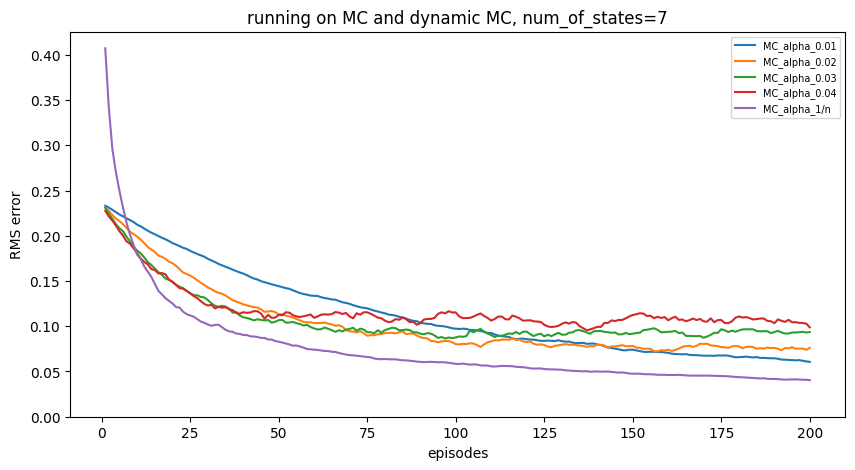

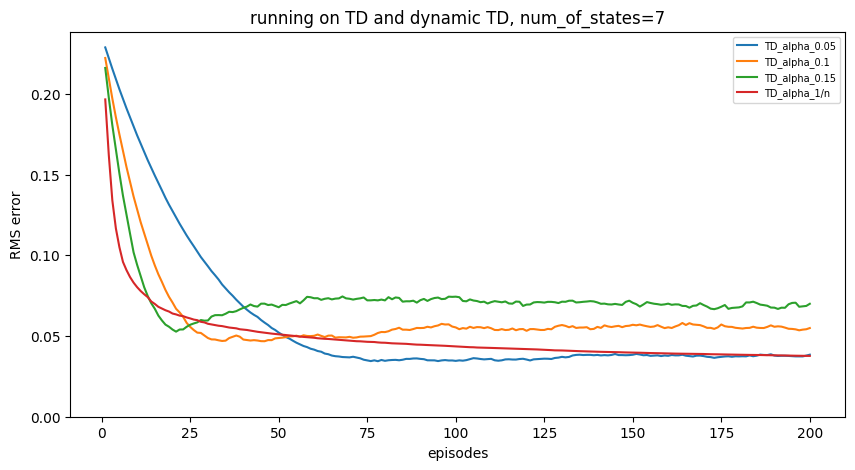

In [9]:
mc_loss_dynamic=[]
td_loss_dynamic=[]
initial_value = [value,]*(env.num_of_states-2)

mc_loss_=np.zeros((max_episode,))
for i in range(max_episode):
    t=run_mc_algo_dynamic_alpha(1,initial_value,max_episode,env)
    mc_loss_+=np.array([RMS_error(env.true_value,t[z]) for  z in range(max_episode)])/max_episode

mc_loss_dynamic=list(mc_loss_)

td_loss_=np.zeros((max_episode,))
for i in range(max_episode):
    t=run_td_algo_dynamic_alpha(1,1,initial_value,max_episode,env)
    td_loss_+=np.array([RMS_error(env.true_value,t[z]) for  z in range(max_episode)])/max_episode

td_loss_dynamic=list(td_loss_)


x_axis = [i+1 for i in range(max_episode)]
fig1=plt.figure(figsize=(10,5))
plt.title(f"running on MC and dynamic MC, num_of_states={env.num_of_states}")
plt.xlabel("episodes")
plt.ylabel("RMS error")
for i in range(len(mc_loss)) :
    plt.plot(x_axis, mc_loss[i],label="MC_alpha_"+str(alpha_mc[i]))
plt.plot(x_axis,mc_loss_dynamic,label="MC_alpha_1/n")
plt.legend(prop={"size":7})
plt.ylim(bottom=0)

fig2=plt.figure(figsize=(10,5))
plt.title(f"running on TD and dynamic TD, num_of_states={env.num_of_states}")
plt.xlabel("episodes")
plt.ylabel("RMS error")
for i in range(len(td_loss)) :
    plt.plot(x_axis, td_loss[i],label="TD_alpha_"+str(alpha_td[i]))
plt.plot(x_axis,td_loss_dynamic,label="TD_alpha_1/n")
plt.legend(prop={"size":7})
plt.ylim(bottom=0)

**Questions**

- Discuss the impact of the exponential moving average alpha in TD and MC algorithm.

**Answer**: The exponential moving average alpha makes both TD and MC curves decrease more smoothly and stably, balance the convergency and decreasing speed. MC with this average alpha has best performance, which can be explained that the average alpha makes unbiased MC's variance lower, improving the performance further. TD with this average alpha has best decrease stability and smoothness, further using "n" to balance the possible bias from one step observation and lowing the variance. Obviously, both TD and MC curves of 1/n alpha are jitter-free (converge) and still decreasing with better performance overall.


### 1.5 Convergence of Exponential Moving Average.

When using a fixed step size $\alpha$ in the MC and TD algorithms, each episode has a non-infinitesimal impact on the current value estimates, preventing the algorithm from fully converging. However, applying exponential moving average (EMA) allows the algorithms to converge.

In the next question, you need to prove that when $\alpha_n=1/n^2$, both MC and TD converge. However, subsequent experiments will demonstrate that such choice of $\{\alpha_n\}$ doesn't ensure convergence to the optimal value. In fact, the conditions under which the algorithms converge to the optimal value can be formally characterized. Those interested may refer to the **Robbins-Monro** condition in stochastic approximation. For those who just want an intuitive understanding, the choice of $\{\alpha_n\}$ should satisfy:
$$\sum_{n=1}^{\infty} \alpha_n = \infty, \sum_{n=1}^{\infty} \alpha_n^2 < \infty$$

**Question**: In MC/TD value learning, we repeated try out a given policy. At the $n$-th trial, we update our value estimate $V_n$ via a collected sampled value $x_n$. Assume the time-varying learning rate is $\alpha_n=1/n^2$ and $\{x_n\}$ and $\{V_n\}$ are bounded sequences, i.e. $\forall n>0, \vert x_n \vert \le C_1$ and $\vert V_n \vert \le C_2$ where $C_1>0$ and $C_2>0$ are some constants. Prove that MC/TD value learning will converge. (Hint: verify that the updating rule $V_n=(1-\alpha_n)V_{n-1}+\alpha_n x_n$ yields a Cauchy sequence $\{V_n\}$.)

**Proof**:

For TD: $V(s)_n=V(s)_{n-1}+\alpha_n(r+\gamma V(s')-V(s)_{n-1})=(1-\alpha_n)V(s)_{n-1}+\alpha_n(r+\gamma V(s'))$.
For MC: $V(s)_n=V(s)_{n-1}+\alpha_n(G-V(s)_{n-1})=(1-\alpha_n)V(s)_{n-1}+\alpha_nG$. Both of them satisfy the form of Cauchy sequence, then prove it.

Cauchy Sequence: $\forall\epsilon>0,\exists N>0,\forall n,m>0,s.t.|V_n-V_m|<\epsilon$.

$\forall n>0$, $V_n-V_{n-1}=\alpha(x_n-V_{n-1})\leq\frac{1}{n^2}(C_1+C_2)$

$\forall m>n$, $|V_m-V_n|=\Sigma_{k=n+1}^m|V_k-V_{k-1}|\leq (C_1+C_2)\Sigma_{k=n+1}^m\frac{1}{k^2}\leq \frac{\pi^2}{6}(C_1+C_2)$.(known convergency)

$\forall \epsilon>0, \exists N$ s.t. $\forall n>N,(C_1+C_2)\Sigma_{k=n+1}^\infty\frac{1}{k^2}\leq \epsilon$ 

Therefore, $\forall m>n>N$, $|V_m-V_n|=\Sigma_{k=n+1}^m|V_k-V_{k-1}|\leq (C_1+C_2)\Sigma_{k=n+1}^m\frac{1}{k^2}\leq (C_1+C_2)\Sigma_{k=n+1}^\infty\frac{1}{k^2}\leq \epsilon$.

Therefore, MC/TD value learning will converge.




(0.0, 0.21162524891291656)

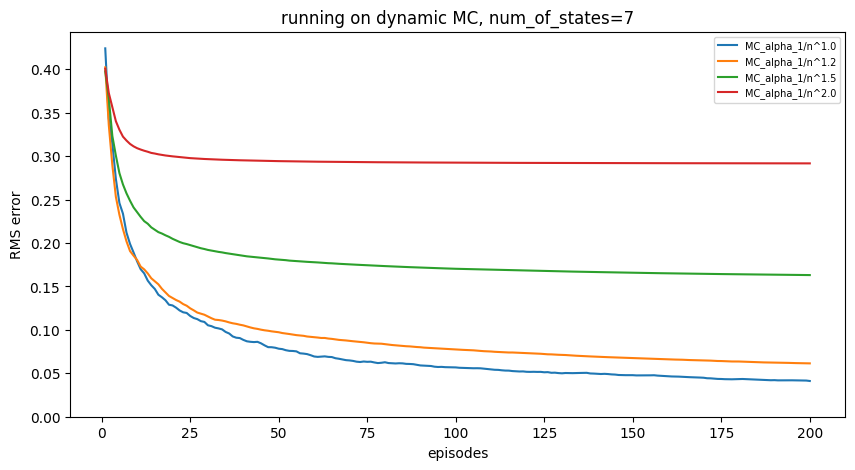

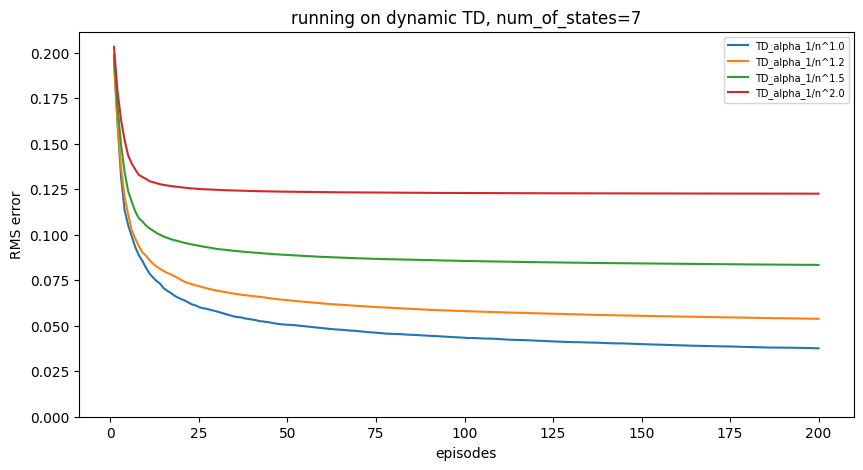

In [10]:
mc_loss_dynamic=[]
td_loss_dynamic=[]
initial_value = [value,]*(env.num_of_states-2)
list_pow = [1.0, 1.2, 1.5, 2.0]

for pow in list_pow:
    mc_loss_=np.zeros((max_episode,))
    for i in range(max_episode):
        t=run_mc_algo_dynamic_alpha(1,initial_value,max_episode,env, pow=pow)
        mc_loss_+=np.array([RMS_error(env.true_value,t[z]) for  z in range(max_episode)])/max_episode
    mc_loss_dynamic.append(list(mc_loss_))

    td_loss_=np.zeros((max_episode,))
    for i in range(max_episode):
        t=run_td_algo_dynamic_alpha(1,1,initial_value,max_episode,env, pow=pow)
        td_loss_+=np.array([RMS_error(env.true_value,t[z]) for  z in range(max_episode)])/max_episode
    td_loss_dynamic.append(list(td_loss_))

x_axis = [i+1 for i in range(max_episode)]
fig1=plt.figure(figsize=(10,5))
plt.title(f"running on dynamic MC, num_of_states={env.num_of_states}")
plt.xlabel("episodes")
plt.ylabel("RMS error")
for i in range(len(list_pow)) :
    plt.plot(x_axis, mc_loss_dynamic[i],label="MC_alpha_1/n^"+str(list_pow[i]))
plt.legend(prop={"size":7})
plt.ylim(bottom=0)

fig2=plt.figure(figsize=(10,5))
plt.title(f"running on dynamic TD, num_of_states={env.num_of_states}")
plt.xlabel("episodes")
plt.ylabel("RMS error")
for i in range(len(list_pow)) :
    plt.plot(x_axis, td_loss_dynamic[i],label="TD_alpha_1/n^"+str(list_pow[i]))
plt.legend(prop={"size":7})
plt.ylim(bottom=0)

## 2 Implementing SARSA and Q-Learning Algorithms in Cliff-Walking

In this part, you are required to implement the SARSA and Q-learning algorithms for the cliff-walking problem. 

### 2.1 Environment description

In this problem, the agent starts in the bottom left corner and is expected to reach the bottom right corner. Stepping into the cliff that segregates those tiles yields a massive negative reward and ends the episode. Otherwise, each step comes at a small cost, meaning the shortest path is the optimal policy (please see codes for more details).

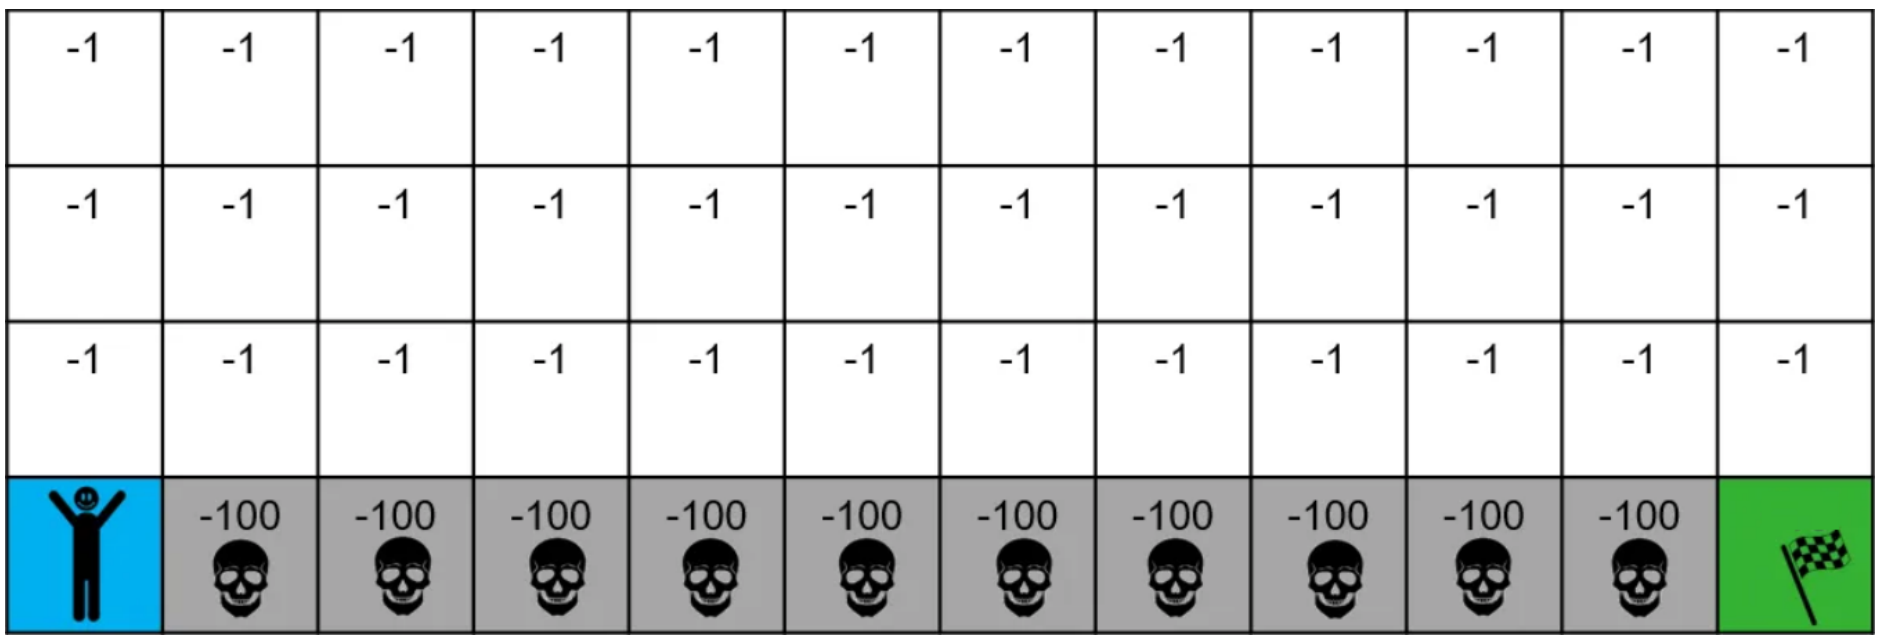


In [11]:
import time
import numpy as np

class Env():
    def __init__(self, length, height):
        self.length = length        
        self.height = height     # map size
        self.x = 0                  
        self.y = 0          # current position

    def render(self, frames=50):
        # render function: display the current environment
        for i in range(self.height):
            if i == 0: 
                # first bottom line : start 😈(-100) terminal
                line = ['S'] + ['x']*(self.length - 2) + ['T'] # the lower left corner is the start point, the lower right corner is the end point
            else:
                # other lines : . means -1
                line = ['.'] * self.length # -1 reward
            if self.x == i:
                line[self.y] = 'o'  # current position
            print(''.join(line))  # print the line
        print('\033['+str(self.height+1)+'A')  # 将终端光标向上移动指定行实现动态刷新终端的效果
        time.sleep(1.0 / frames)

    def step(self, action):
        """4 legal actions, 0:up, 1:down, 2:left, 3:right"""
        # give action and execute step
        change = [[0, 1], [0, -1], [-1, 0], [1, 0]]   # move direction

        tx, ty = self.x + change[action][0], self.y + change[action][1]  # position after change
        self.x = min(self.height - 1, max(0, tx))
        self.y = min(self.length - 1, max(0, ty))  # avoid out of bounds
 
        states = [self.x, self.y]   # update position
        reward = -1  # default reward
        terminal = False
        if self.x == 0: 
            if self.y > 0:
                # bottom line and not the start point is terminal
                terminal = True
                if self.y != self.length - 1:
                    reward = -100  # 😈
        return reward, states, terminal

    def reset(self):
        # reset the environment
        self.x = 0
        self.y = 0

### 2.2 Implementing the $\epsilon$-greedy policy

Below is the base Q table for SARSA and Q-learning. 

**Coding exercise.** Please implement the $\epsilon$-greedy policy in `take_action()`.

In [ ]:
class Base_Q_table():
    def __init__(self, length, height, actions=4, alpha=0.1, gamma=0.9, eps=0.1):
        self.table = [0] * actions * length * height
        self.actions = actions
        self.length = length
        self.height = height
        self.alpha = alpha
        self.gamma = gamma
        self.eps = eps

    def _index(self, a, x, y):
        # a,x,y: action(a), x, y position(s)
        # return the index of Q table
        return a * self.height * self.length + x * self.length + y

    def best_action(self, x, y):
        '''
        return: the best action of current position (x,y)
        '''
        mav = -100000
        mapos = -1  # store the best action
        change = [[0, 1], [0, -1], [-1, 0], [1, 0]]
        for i in range(self.actions):            
            tx, ty = x + change[i][0], y + change[i][1]
            if (min(tx, ty)<0 or tx>=self.height or ty>=self.length):
                # out of bounds
                continue
            if(self.table[self._index(i,x,y)] > mav):
                mav = self.table[self._index(i,x,y)]  # choose max Q(s,a)
                mapos = i
        return mapos

    def _epsilon(self, num_episode=0):
        return self.eps

    def max_q(self, x, y):
        action = self.best_action(x, y)
        return self.table[self._index(action,x,y)]
        
    def take_action(self, x, y, num_episode=1, method='eps_greedy'):
        '''
        method: 'eps_greedy' denotes that taking actions using epsilon greedy (used as the policy for SARSA, and the behavior policy for Q-Learning), 
        'full_greedy' denotes that taking actions fully greedy w.r.t. the current estimated Q table.
        '''

        """ YOUR CODE HERE """
        action = self.best_action(x, y)  # choose the best action

        if method == 'eps_greedy':
            if np.random.rand() < self._epsilon(num_episode):
                # eps greedy, random choose an action
                action = np.random.randint(self.actions)
                # 不需要考虑越界问题——如果选错了step里面会自动处理min掉
            
        return action

    def update(self, direct, next_direct, s0, s1, reward, is_terminated):
        pass
        # left for specific algorithm: update Q
        
    

### 2.3 Implementing the SARSA algorithm

**Coding exercise.**  In the following code, please implement the `update()` function, which updates the Q-table for SARSA, and the `cliff_walk()` function, which instantiates the SARSA algorithm.

In [ ]:
class Q_table_sarsa(Base_Q_table):
    def __init__(self, length, height, actions=4, alpha=0.1, gamma=0.9, eps=0.1):
        super().__init__(length, height, actions, alpha = alpha, gamma = gamma, eps=eps)

    def update(self, direct, next_direct, s0, s1, reward, is_terminated):
        """ YOUR CODE HERE """
        # SARSA update rule: Q(s,a) = Q(s,a) + alpha * (r + gamma * Q(s',a') - Q(s,a))
        cur_qsa = self.table[self._index(direct, s0[0], s0[1])]  # Q(s,a)
        prime_qsa = self.table[self._index(next_direct, s1[0], s1[1])]  # Q(s',a')
        new_qsa = cur_qsa + self.alpha * (reward + self.gamma * prime_qsa - cur_qsa)
        self.table[self._index(direct, s0[0], s0[1])] = new_qsa  # update Q(s,a)
        # 如果s1是终止状态，其Q没有更新的机会，一直是0。其实没有什么影响，因为r还是存在的

        return

    def cliff_walk(self):
        """ YOUR CODE HERE """
        # use update and take_action there: 执行算法的调用接口
        rewards = []
        env = Env(self.length, self.height)  # create the environment
        for i in range(1000):  # 1000 episodes
            env.reset()
            cum_reward = 0
            x, y = env.x, env.y  # current position
            direct = self.take_action(x, y, self.eps, method='eps_greedy')  # eps greedy a
            while True:
                reward, next_state, terminate = env.step(direct)  # r s'
                # terminate表示走了action之后是否到达了终止状态，即s'
                next_direct = self.take_action(env.x, env.y, self.eps, method='eps_greedy')  # eps greedy a'， env内部更新了x,y
                self.update(direct, next_direct, (x, y), (env.x, env.y), reward, terminate)
                cum_reward += reward
                if terminate:
                    # 如果走到下一步s'是终止状态，需要更新Q
                    rewards.append(cum_reward)
                    break
                x, y = env.x, env.y  # current position，env内更新了x,y
                direct = next_direct

        # 返回值应该是每次探索累积reward形成的list
        return rewards

### 2.4 Implementing the Q-learning algorithm

**Coding exercise.**  In the following code, please implement the `update()` function, which updates the Q-table for Q-learning, and the `cliff_walk()` function, which instantiates the Q-learning algorithm.

In [23]:
class Q_table_qlearning(Base_Q_table):
    def __init__(self, length, height, gamma, actions=4, alpha=0.005, eps=0.1):
        super().__init__(length, height, actions, alpha = alpha, gamma = gamma, eps=eps)

    def update(self, a, s0, s1, r, is_terminated):
        """ YOUR CODE HERE """
        # Q learning algorithm: Q(s,a)=Q(s,a)+alpha*(r+gamma*maxQ(s',a')-Q(s,a))
        # choose action: a is mu, a' is pi
        # direct: a, next_direct: a'
        # s0: current s xy, s1: next s' xy
        # reward: r, is_terminated: terminal flag
        cur_qsa = self.table[self._index(a, s0[0], s0[1])]  # Q(s,a)
        prime_qsa = self.max_q(s1[0], s1[1])  # max Q(s',a')
        new_qsa = cur_qsa + self.alpha * (r + self.gamma * prime_qsa - cur_qsa)
        self.table[self._index(a, s0[0], s0[1])] = new_qsa
        # 更无需关心终止状态，如果s是，则进不来
        return

    def cliff_walk(self):
        """ YOUR CODE HERE """
        reward_eps_greedy, reward_full_greedy = [], []  # behavior, target
        behaviour_env = Env(self.length, self.height)  # create the environment
        target_env = Env(self.length, self.height)

        # 过程：先eps_greedy采样更新policy Q直到结束，再full_greedy采样评估policy Q

        for i in range(1000):  # 1000 episodes
            behaviour_env.reset()
            cum_reward_eps_greedy = 0
            cum_reward_full_greedy = 0

            # 第一步：eps greedy采样更新policy Q
            while True:
                x, y = behaviour_env.x, behaviour_env.y  # current position s
                direct = self.take_action(x, y, self.eps, method='eps_greedy')  # eps greedy a
                reward, next_state , terminal = behaviour_env.step(direct)  # r s' behavior: s'
                self.update(direct, (x, y), next_state, reward, terminal)  # 更新Q(s,a)
                cum_reward_eps_greedy += reward
                if terminal:
                    reward_eps_greedy.append(cum_reward_eps_greedy)
                    break
            # print("reward_eps_greedy", cum_reward_eps_greedy)

            # 第二步：full greedy采样评估policy Q
            # 这里会卡死，需要限制步数
            target_env.reset()
            step = 0
            while True:
                x, y = target_env.x, target_env.y
                direct = self.take_action(x, y, self.eps, method='full_greedy')
                reward, next_state, terminal = target_env.step(direct)
                cum_reward_full_greedy += reward
                step += 1
                if terminal or step >= 100:
                    reward_full_greedy.append(cum_reward_full_greedy)
                    break
            # print("reward_full_greedy", cum_reward_full_greedy)

        return reward_eps_greedy, reward_full_greedy

### 2.5 Comparing the performance

Please run the following code to evaluate SARSA and Q-learning with different values of $\epsilon$ in $\epsilon$-greedy. You need to show

- the performance of the SARSA algorithm with different values of $\epsilon$ in $\epsilon$-greedy;
- the performance of the Q-learning algorithm with different values of $\epsilon$ in $\epsilon$-greedy;
- the performance of Q-learning algorithm with different values of $\epsilon$ in $\epsilon$-greedy but using the **target policy** (*i.e.*, the learned optimal policy in each episode).

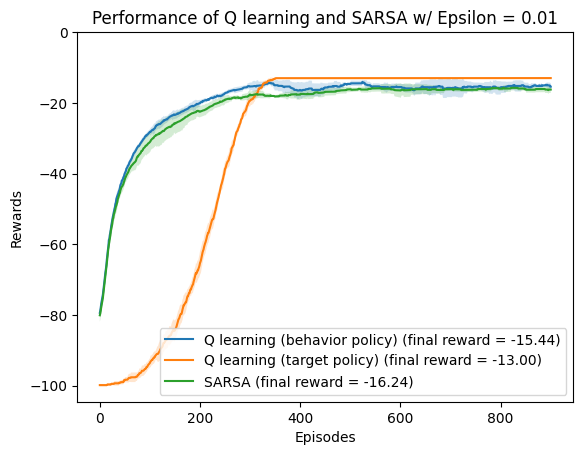

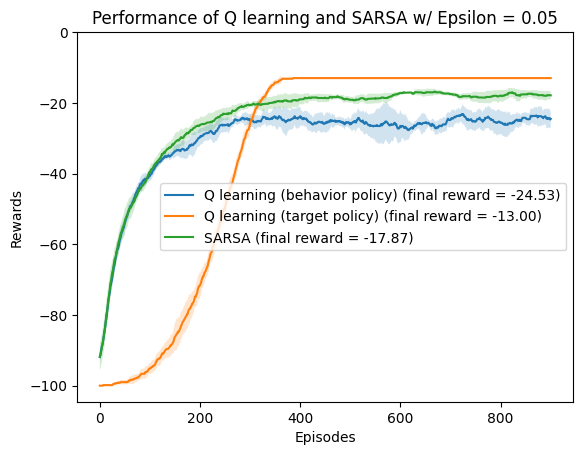

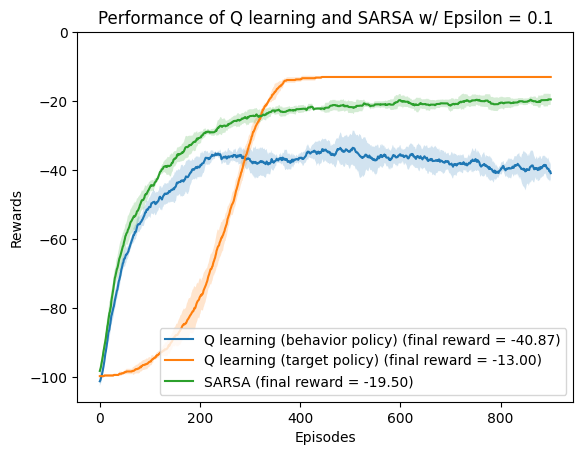

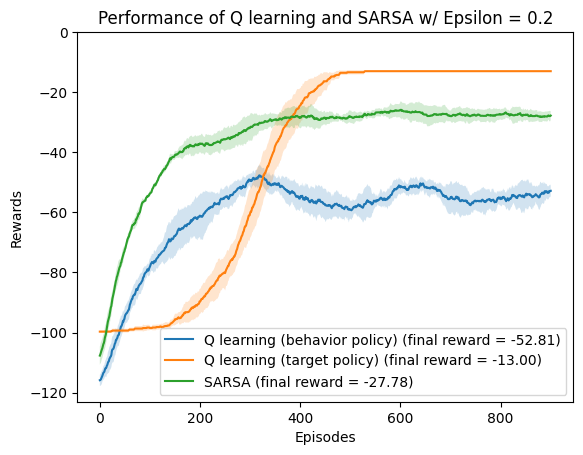

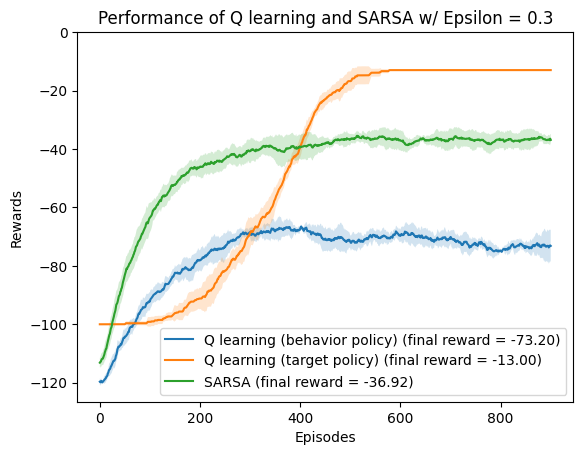

<Figure size 640x480 with 0 Axes>

In [25]:
import numpy as np
import matplotlib.pyplot as plt

def plot_moving_average(data, label, window_size=100):
    # data：二维数组，每一行表示一个seed下的结果
    def moving_average(x, w):
        # 计算每一行的滑动平均值：长度为w的全1窗口，相当于一次可以走的最长步数。
        # np.convolve：一维卷积；valid滑动平均/w：是在计算每个长为w窗口内的奖励平均值
        return np.convolve(x, np.ones(w), 'valid') / w
    moving_averages = np.array([moving_average(row, window_size) for row in data]) # moving average for each row，一维
    mean_moving_averages = moving_averages.mean(axis=0)  # axis=0表示对每一列求平均值
    std_dev_moving_averages = moving_averages.std(axis=0) # axis=0表示对每一列求标准差
    plt.plot(mean_moving_averages, label=f"{label} (final reward = {mean_moving_averages[-1]:.2f})")
    plt.fill_between(range(len(mean_moving_averages)),
                     mean_moving_averages - std_dev_moving_averages,
                     mean_moving_averages + std_dev_moving_averages, 
                     alpha=0.2)


height, length = 4, 12
gamma = 0.95
alpha = 0.1
eps_list = [0.01, 0.05, 0.1, 0.2, 0.3]
reward_qlearning_behavior_policys = {}
reward_qlearning_target_policys = {}
reward_sarsas = {}
for eps in eps_list:
    # for every eps, record the rewards
    reward_qlearning_behavior_policys[eps] = []
    reward_qlearning_target_policys[eps] = []
    reward_sarsas[eps] = []
for eps in eps_list:
    seeds = [42, 43, 44, 45, 46]
    for seed in seeds:
        # Q-learning
        agent = Q_table_qlearning(height = height, length = length, gamma = gamma, eps = eps, alpha = alpha)
        reward_qlearning_behavior_policy, reward_qlearning_target_policy = agent.cliff_walk()
        reward_qlearning_behavior_policys[eps].append(reward_qlearning_behavior_policy)
        reward_qlearning_target_policys[eps].append(reward_qlearning_target_policy)
        # SARSA
        agent = Q_table_sarsa(height = height, length = length, gamma = gamma, eps = eps, alpha = alpha)
        reward_sarsa = agent.cliff_walk()  # returns the reward of each episode
        reward_sarsas[eps].append(reward_sarsa)  # 一维，一行是按顺序记录探索的累积奖励。在不同的seed下构成多行


for eps in eps_list:
    plot_moving_average(reward_qlearning_behavior_policys[eps], f"Q learning (behavior policy)")
    plot_moving_average(reward_qlearning_target_policys[eps], f"Q learning (target policy)")
    plot_moving_average(reward_sarsas[eps], f"SARSA")
    plt.xlabel("Episodes")
    plt.ylabel("Rewards")
    plt.title(f"Performance of Q learning and SARSA w/ Epsilon = {eps}")
    plt.legend()
    plt.ylim(None, 0)
    plt.show()
    plt.clf()


**Questions.**  Please compare the performance of the algorithms in the above cases and give discussions about

- What are the impacts of different values of $\epsilon$ on the performance of the above three algorithms? Explain the reasons.

**Answer**: As epsilon gets bigger, the rewards of full-greedy target policy don't change, but the final reward of the behavior policy and SARSA using epsilon-greedy decreases significantly, and the reward of behavior policy of Q-learning is lower. However, they all converge more slowly. The larger the epsilon, the more inclined it is to explore, rather than following the trend of the learned Q. So it will execute the non-optimal policy, resulting in a smaller final reward value. But this does not mean that the learned Q function is not good enough. It's just that epsilon-greedy doesn't strictly follow the Q function to execute, but is more inclined to explore. In addition, when Q-learning is updated, the a' of the second step is not sampled, but is selected strictly by the maximum reward of Q. For the cliff problem as shown in the figure, this will cause the algorithm to get closer and closer to the cliff when exploring, and it is easier to fall into the cliff to get a lower reward value in the case of high epsilon, so the final reward of the behavior policy is more lower than that of the SARSA algorithm.


- Discuss the difference between SARAS and Q-learning algorithms. Why is SARAR called an on-policy algorithm and the Q-learning algorithm called an off-policy one?

**Answer**: The difference between Sarsa and Q-learning is the difference of choosing a' for the state s' when updating/learning the Q function. The Sarsa algorithm samples a' based on the current Q function and policy, but Q-learning selects a' with largest Q(s',a') according to the target policy, and its s is selected from the behavior policy. There is no other difference between the two algorithms. Sarsa updates the current policy with the current policy, so it's on-policy. Q-learning updates/evaluates the target policy according to the behavior policy choosing a, and the objective of using and learning policy is also the target policy, so it is off-policy.

- What is the difference between the performance of the **behavior policy** of Q-learning algorithm and the performance of the **target policy** of Q-learning algorithm? Explain the reasons.

**Answer**: The performance of target policy does not effected by epsilon, but the performance(final reward) of behavior policy is getting lower as the increasing of epsilon. The reason is that the target policy uses full-greedy and the behavior policy uses epsilon-policy. The target policy will strictly follow the learned Q function to select the best action to ensure that each step is optimal, and the optimal strategy for this problem is obviously walking along the cliff. The behavior policy selects the optimal actions and explores randomly with a certain probability, which is easy to fall down when walking along the cliff, and the larger the epsilon, the easier it is to fall, so the reward is very low. But this does not affect updating Q to the optimum.


### 2.6 Trajectory Visualization and Discussion of the Learned Policies

Please print out the actions under different states for the policy finally learned by SARSA and Q-learning and analyze why such results were obtained. For instance, explore whether the policy learned by different algorithms varies and the reasons behind these differences.

In [26]:
def print_policy(policy):
    states = [[-1 for _ in range(12)] for _ in range(4)]
    arrow_mapping = {
        -1: '.',
        0: '\u2192',
        1: '\u2190',
        2: '\u2193',
        3: '\u2191'
    }
    env = Env(length=12, height=4)
    is_terminated = False
    s0 = [0, 0]
    record = []
    action = policy.take_action(s0[0], s0[1], 1)
    while not is_terminated:
        _, s1, is_terminated = env.step(action)
        if s0 != s1:
            record.append((s0, action))
        next_action = policy.take_action(s1[0], s1[1], 1)
        s0 = s1
        action = next_action
    for r in record:
        (x, y), a = r
        states[x][y] = a
    for x in range(3, -1, -1):
        for y in range(12):
            print(arrow_mapping[states[x][y]], end='')
        print()
    return 

def print_best_action_policy(policy):
    states = [[-1 for _ in range(12)] for _ in range(4)]
    arrow_mapping = {
        -1: '.',
        0: '\u2192',
        1: '\u2190',
        2: '\u2193',
        3: '\u2191'
    }
    env = Env(length=12, height=4)
    is_terminated = False
    s0 = [0, 0]
    record = []
    action = policy.best_action(s0[0], s0[1])
    while not is_terminated:
        _, s1, is_terminated = env.step(action)
        if s0 != s1:
            record.append((s0, action))
        next_action = policy.best_action(s1[0], s1[1])
        s0 = s1
        action = next_action
    for r in record:
        (x, y), a = r
        states[x][y] = a
    for x in range(3, -1, -1):
        for y in range(12):
            print(arrow_mapping[states[x][y]], end='')
        print()
    return

In [42]:
# For Q-learning (behavior policy):
eps_list = [0.0, 0.1, 0.2, 0.3]
for eps in eps_list:
    agent = Q_table_qlearning(height = height, length = length, gamma = gamma, eps = eps, alpha = alpha)
    agent.cliff_walk()
    print(f"Q learning (behavior) policy w/ epsilon = {eps}:")
    print_policy(agent)

Q learning (behavior) policy w/ epsilon = 0.0:
............
............
→→→→→→→→→→→↓
↑...........
Q learning (behavior) policy w/ epsilon = 0.1:
............
............
→→→→→→→→→→→↓
↑...........
Q learning (behavior) policy w/ epsilon = 0.2:
.↓←.........
.→→→→→→→→→↓.
→↑........→↓
↑...........
Q learning (behavior) policy w/ epsilon = 0.3:
............
....→→→→↓...
→→→→↑...→→→↓
↑...........


In [28]:
# For Q-learning (target policy):
eps_list = [0.0, 0.1, 0.2, 0.3]
for eps in eps_list:
    agent = Q_table_qlearning(height = height, length = length, gamma = gamma, eps = eps, alpha = alpha)
    agent.cliff_walk()
    print(f"Q learning (target) policy w/ epsilon = {eps}:")
    print_best_action_policy(agent)

Q learning (target) policy w/ epsilon = 0.0:
............
............
→→→→→→→→→→→↓
↑...........
Q learning (target) policy w/ epsilon = 0.1:
............
............
→→→→→→→→→→→↓
↑...........
Q learning (target) policy w/ epsilon = 0.2:
............
............
→→→→→→→→→→→↓
↑...........
Q learning (target) policy w/ epsilon = 0.3:
............
............
→→→→→→→→→→→↓
↑...........


In [35]:
# For SARSA:
eps_list = [0.0, 0.1, 0.2, 0.3]
for eps in eps_list:
    agent = Q_table_sarsa(height = height, length = length, gamma = gamma, eps = eps, alpha = alpha)
    agent.cliff_walk()
    print(f"SARSA policy w/ epsilon = {eps}:")
    print_policy(agent)

SARSA policy w/ epsilon = 0.0:
............
............
→→→→→→→→→→→↓
↑...........
SARSA policy w/ epsilon = 0.1:
→→→→→→→→→→↓.
↑.........→↓
↑..........↓
↑...........
SARSA policy w/ epsilon = 0.2:
→→→→→→→→→↓..
↑........→→↓
↑..........↓
↑...........
SARSA policy w/ epsilon = 0.3:
→→→→→→→→→→→↓
↑..........↓
↑..........↓
↑...........


In [41]:
# For SARSA (argmax policy):
eps_list = [0.0, 0.1, 0.2, 0.3]
for eps in eps_list:
    agent = Q_table_sarsa(height = height, length = length, gamma = gamma, eps = eps, alpha = alpha)
    agent.cliff_walk()
    print(f"SARSA argmax policy w/ epsilon = {eps}:")
    print_best_action_policy(agent)

SARSA argmax policy w/ epsilon = 0.0:
............
............
→→→→→→→→→→→↓
↑...........
SARSA argmax policy w/ epsilon = 0.1:
............
→→→→→→→→→→→↓
↑..........↓
↑...........
SARSA argmax policy w/ epsilon = 0.2:
→→→→→→→→→→→↓
↑..........↓
↑..........↓
↑...........
SARSA argmax policy w/ epsilon = 0.3:
.→→→→→→→→→→↓
→↑.........↓
↑..........↓
↑...........


Specifically, here we define four policies:

1. $\pi_1$: a safer policy from the starting point to the target, and when not in the trajectory, the agent will go towards the trajectory (trajectory is shown in the figure below, and please refer to `Pi_1` for the implementation);
2. $\pi_2$: a more radical policy from the starting point to the target and when not in the trajectory, the agent will go towards the trajectory (trajectory is shown in the figure below, and please refer to `Pi_2` for the implementation);
3. $\pi_3$: $\pi_1$, but with a probability of $0.2$ to go randomly at each step (please refer to `Pi_3` for the implementation);
4. $\pi_4$: $\pi_2$, but with a probability of $0.2$ to go randomly at each step (please refer to `Pi_4` for the implementation).

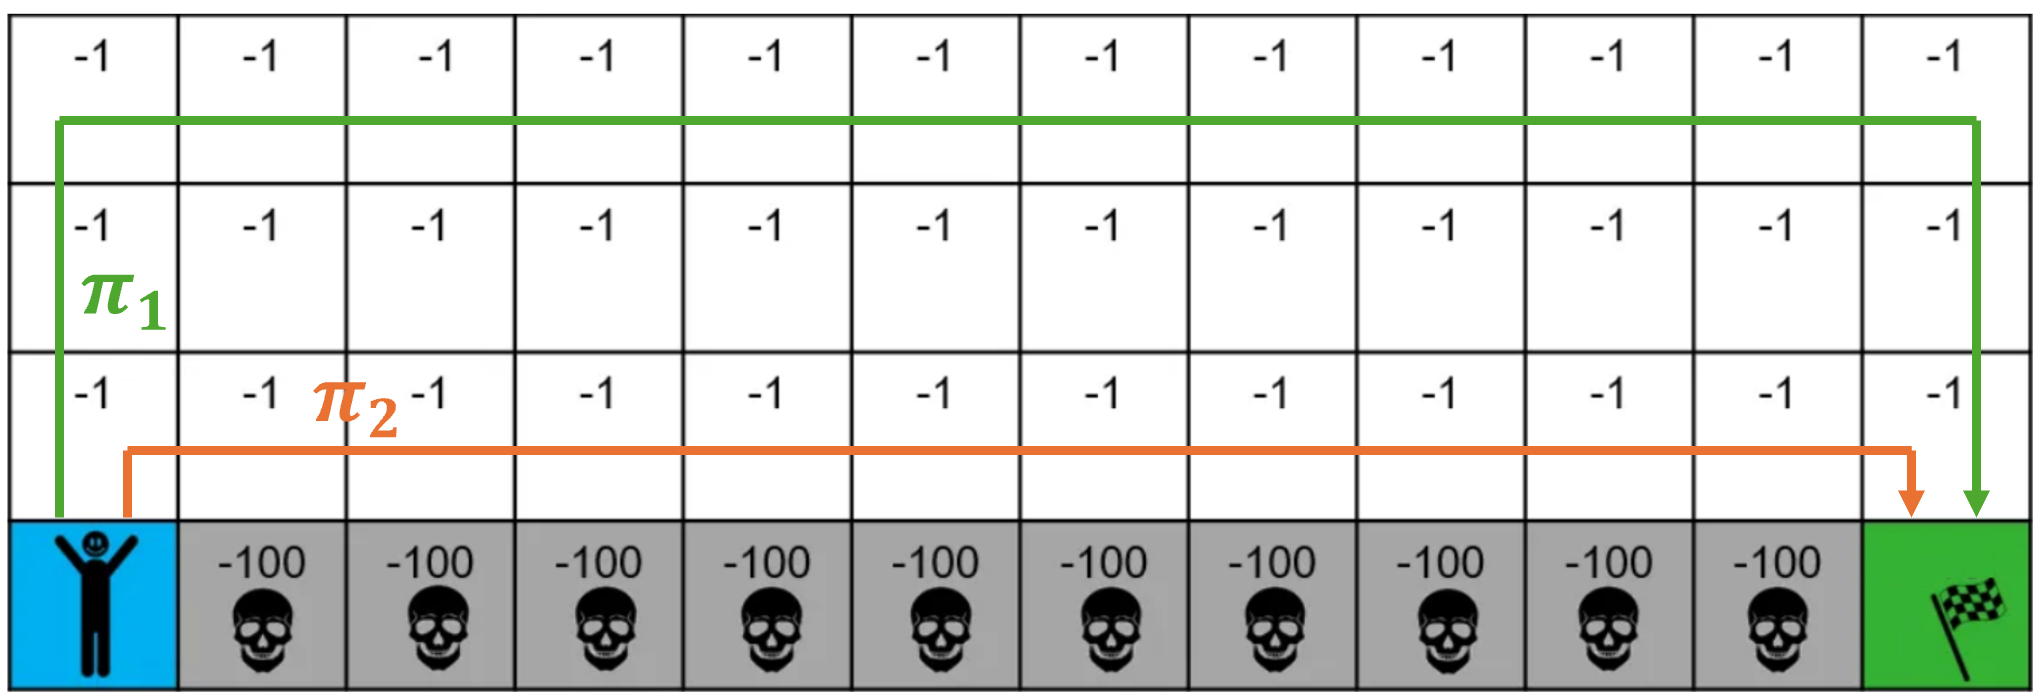


In [31]:
import random

class Pi_1:
    def __init__(self):
        self.action_table = [
            [+3, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, +2],
            [+3, +3, +3, +3, +3, +3, +3, +3, +3, +3, +3, +2],
            [+3, +3, +3, +3, +3, +3, +3, +3, +3, +3, +3, +2],
            [+0, +0, +0, +0, +0, +0, +0, +0, +0, +0, +0, +2],
        ]
    def take_action(self, x, y):
        return self.action_table[x][y]

class Pi_2:
    def __init__(self):
        self.action_table = [
            [+3, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, +2],
            [+0, +0, +0, +0, +0, +0, +0, +0, +0, +0, +0, +2],
            [+2, +2, +2, +2, +2, +2, +2, +2, +2, +2, +2, +2],
            [+2, +2, +2, +2, +2, +2, +2, +2, +2, +2, +2, +2],
        ]
    def take_action(self, x, y):
        return self.action_table[x][y]


class Pi_3:
    def __init__(self):
        self.action_table = [
            [+3, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, +2],
            [+3, +3, +3, +3, +3, +3, +3, +3, +3, +3, +3, +2],
            [+3, +3, +3, +3, +3, +3, +3, +3, +3, +3, +3, +2],
            [+0, +0, +0, +0, +0, +0, +0, +0, +0, +0, +0, +2],
        ]
    def take_action(self, x, y):
        if random.uniform(0, 1) < 0.2 or self.action_table[x][y] == -1:
            return random.randint(0, 3)
        else:
            return self.action_table[x][y]


class Pi_4:
    def __init__(self):
        self.action_table = [
            [+3, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, +2],
            [+0, +0, +0, +0, +0, +0, +0, +0, +0, +0, +0, +2],
            [+2, +2, +2, +2, +2, +2, +2, +2, +2, +2, +2, +2],
            [+2, +2, +2, +2, +2, +2, +2, +2, +2, +2, +2, +2],
        ]
    def take_action(self, x, y):
        if random.uniform(0, 1) < 0.2 or self.action_table[x][y] == -1:
            return random.randint(0, 3)
        else:
            return self.action_table[x][y]

pi_1 = Pi_1()
pi_2 = Pi_2()
pi_3 = Pi_3()
pi_4 = Pi_4()

Please complete the function `compute_Q_table` below, which will recalculate the Q table under a given policy. We will use this function to compute the Q tables for pi_1, pi_2, pi_3, and pi_4, as well as recalculate the Q tables corresponding to the policies ultimately learned through the SARSA policy, Q learning behavior policy, and Q learning target policy. You may refer to the following equation during your recursive computation:
$$
Q^\pi(s,a) = \sum_{s'}T(s,a,s')\left[R(s,a,s') + \gamma \sum_{a'} \pi(a'|s') Q^\pi(s',a')\right]
$$

In [46]:
eps=0.2

def compute_Q_table(q_table, policy, num_episodes=10000, next_action_sample_size=40):

    """ YOUR CODE HERE """
    # 迭代num_episodes次，每次均为完整轨迹，更新Q时，采样next_action_sample_size次，按照本次采样的policy更新
    env = Env(q_table.length, q_table.height)  

    for i in range(num_episodes):
        env.reset()  # reset the environment
        x, y = env.x, env.y

        while True:
            action = policy.take_action(x, y)  # s->a
            reward, next_state, terminal = env.step(action)  # terminal表示s'是否是终止状态   s,a->s',r

            total_qsa_next = 0  # Q(s',a')的总和
            # 如果是终止状态，所有的Q(s',a')都是0，简化计算，不再采样
            if terminal:
                total_qsa_next = 0  # Q(s',a') = 0
            else:
                for j in range(next_action_sample_size):
                    next_action = policy.take_action(next_state[0], next_state[1]) # s'->a'
                    total_qsa_next += q_table.table[q_table._index(
                        next_action, next_state[0], next_state[1])]  # Q(s',a')
            avg_qsa_next = total_qsa_next / next_action_sample_size  # Σpi*Q(s',a')

            index=q_table._index(action, x, y)  # Q(s,a) idx
            q_table.table[index] = reward + q_table.gamma * avg_qsa_next  # update Q(s,a) using the average Q(s',a')

            if terminal:
                break

            x, y = next_state[0], next_state[1]  # 更新s<-s'

    return q_table


q_table = Base_Q_table(12, 4, gamma=0.95, eps=eps, alpha=0.1)
policy1_table = np.array(compute_Q_table(q_table, pi_1).table)
q_table = Base_Q_table(12, 4, gamma=0.95, eps=eps, alpha=0.1)
policy2_table = np.array(compute_Q_table(q_table, pi_2).table)
q_table = Base_Q_table(12, 4, gamma=0.95, eps=eps, alpha=0.1)
policy3_table = np.array(compute_Q_table(q_table, pi_3).table)
q_table = Base_Q_table(12, 4, gamma=0.95, eps=eps, alpha=0.1)
policy4_table = np.array(compute_Q_table(q_table, pi_4).table)

q_table = Base_Q_table(12, 4, gamma=0.95, eps=eps, alpha=0.1)
agent = Q_table_sarsa(height = height, length = length, gamma = gamma, eps = eps, alpha = alpha)
agent.cliff_walk()
SARSA_table = np.array(compute_Q_table(q_table, agent).table)

q_table = Base_Q_table(12, 4, gamma=0.95, eps=eps, alpha=0.1)
agent = Q_table_qlearning(height = height, length = length, gamma = gamma, eps = eps, alpha = alpha)
agent.cliff_walk()
Q_learning_behavior_table = np.array(compute_Q_table(q_table, agent).table)


class Q_learning_target:
    def __init__(self, agent):
        self.agent = agent
    def take_action(self, x, y):
        return self.agent.best_action(x, y)
q_table = Base_Q_table(12, 4, gamma=0.95, eps=eps, alpha=0.1)
Q_learning_target_table = np.array(compute_Q_table(q_table, Q_learning_target(agent)).table)


def compare_Q_tables(table1, table2):
    return np.average(abs(np.array(table1) - np.array(table2)))

print("Comparing SARSA Q table with pre-defined policies:")
print("With pi_1: ", compare_Q_tables(SARSA_table, policy1_table))
print("With pi_2: ", compare_Q_tables(SARSA_table, policy2_table))
print("With pi_3: ", compare_Q_tables(SARSA_table, policy3_table))
print("With pi_4: ", compare_Q_tables(SARSA_table, policy4_table))

print("Comparing Q-learning behavior table with pre-defined policies:")
print("With pi_1: ", compare_Q_tables(Q_learning_behavior_table, policy1_table))
print("With pi_2: ", compare_Q_tables(Q_learning_behavior_table, policy2_table))
print("With pi_3: ", compare_Q_tables(Q_learning_behavior_table, policy3_table))
print("With pi_4: ", compare_Q_tables(Q_learning_behavior_table, policy4_table))

print("Comparing Q-learning target table with pre-defined policies:")
print("With pi_1: ", compare_Q_tables(Q_learning_target_table, policy1_table))
print("With pi_2: ", compare_Q_tables(Q_learning_target_table, policy2_table))
print("With pi_3: ", compare_Q_tables(Q_learning_target_table, policy3_table))
print("With pi_4: ", compare_Q_tables(Q_learning_target_table, policy4_table))

Comparing SARSA Q table with pre-defined policies:
With pi_1:  12.098900363260226
With pi_2:  12.327107320224158
With pi_3:  2.6088281056165443
With pi_4:  10.81317763377435
Comparing Q-learning behavior table with pre-defined policies:
With pi_1:  19.7853355176214
With pi_2:  20.013542474585336
With pi_3:  8.485493018298415
With pi_4:  4.504665119782423
Comparing Q-learning target table with pre-defined policies:
With pi_1:  0.8983823039618722
With pi_2:  0.0
With pi_3:  11.958483542105244
With pi_4:  22.229104966596992



In the code above, we utilize the `compare_Q_tables` function to assess the similarity among different Q tables. Specifically, we evaluate the similarity of the SARSA Q table, Q learning behavior policy Q table, and Q learning target policy Q table against pi_1, pi_2, pi_3, and pi_4. 

**Questions.** Based on this analysis, please answer the following questions:

- Determine which of the four manually defined policies ($\pi_1, \pi_2, \pi_3, \pi_4$) most closely resembles the SARSA policy, as well as the Q-learning (behavior) policy and Q-learning (target) policy, based on their Q-tables. You may draw conclusions from various perspectives, such as the visualized trajectories and the degree of similarity in the Q tables. 

**Answer**: From the perspective of degree of similarity in the Q-tables, $\pi_3$ is most closely resembles the Sarsa policy, $\pi_4$ is most closely resembles the Q-learning behavior policy and $\pi_2$ is most closely resembles the Q-learning target policy. From the perspective of visualized trjectories, $\pi_3$ is most closely resembles the Sarsa policy whose chosen path is farthest away from cliff and with epsilon-exploration; $\pi_4$ is most closely resembles the Q-learning behavior policy whose chosen path is closest to the cliff and with epsilon-exploration; $\pi_2$ is most closely resembles the Q-learning target policy whose chosen path is closest to the cliff and with no exploration.

- Please provide a detailed analysis of the reasons behind these results.

**Answer**: $\pi_3$ is most closely resembles the SARSA policy. It is ε-greedy and on-policy, so it will learn a safer policy whose chosen path is farthest away from cliff to avoid falling off. Q-learning use behavior policy to epsilon-exploration but take next action with full-greedy target policy and update Q with $\max Q(s',a')$, so it can learn the optimal but dangerous path. The behavior policy with ε-greedy has probability to fall into cliff but target policy doesn't. Therefore, $\pi_4$ is most closely resembles the Q-learning behavior policy. whose chosen path is closest to the cliff and with epsilon-exploration. $\pi_2$ is most closely resembles the Q-learning target policy whose chosen path is closest to the cliff and with no exploration.